# Imports

In [23]:
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
import torch.nn as F
import torchvision.transforms as transforms
import torchmetrics
import numpy as np

print(torch.version.cuda)

12.1


# Set Device

In [24]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"using {device} device")

using cuda device


# Import MNIST Dataset

In [25]:
batch_size = 64

train_dataset = datasets.CIFAR10(root = './data',
                               train = True,
                               transform = transforms.Compose([
                                   transforms.Resize((32,32)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.1325,), std = (0.3105,))]),
                               download = True
                               )

test_dataset = datasets.CIFAR10(root='./data',
                               train=False,
                               transform=transforms.Compose([
                                   transforms.Resize((32, 32)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.1325,), std=(0.3105,))]),
                               download=True
                               )
        
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


# Set up the LeNet CNN

In [26]:
class LeNet_mod(F.Module):
    def __init__(self, num_classes):
        super(LeNet_mod, self).__init__()
        self.layer1 = F.Sequential(
            F.Conv2d(3, 13, kernel_size = 5, stride=1, padding = 0),
            F.BatchNorm2d(13),
            F.ReLU(),
            F.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = F.Sequential(
            F.Conv2d(13, 60, kernel_size = 5, stride=1, padding = 0),
            F.BatchNorm2d(60),
            F.ReLU(),
            F.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = F.Linear(1500,360)
        self.relu = F.ReLU()
        self.fc1 = F.Linear(360,256)
        self.relu1 = F.ReLU()
        self.fc2 = F.Linear(256,num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

# Epoch tests
### Hyperparameters

In [27]:
num_classes = 100
learning_rate = 0.001
num_epochs = 60

metric_f1 = torchmetrics.F1Score(task='multiclass', num_classes = num_classes).to(device)

### Set up the CNN for use

In [28]:
model = LeNet_mod(num_classes = num_classes).to(device)

cost = F.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)

accuracy = []

f1 = []

### Run the CNN
Record the accuracy at the end of each epoch

In [29]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = cost(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        metric_f1.update(outputs, labels)
        
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total+=labels.size(0)
            correct+=(predicted == labels).sum().item()
        accuracy.append(100 * correct / total)
        f1.append((100* metric_f1.compute()))
        print(f'Epoch {epoch+1}/{num_epochs}.. ')
        print(f'F1Score: {f1[-1]:.4f}%')
        print(f'Accuracy: {accuracy[-1]:.4f}%')
        

Epoch 1/60.. 
F1Score: 50.7880%
Accuracy: 58.0700%
Epoch 2/60.. 
F1Score: 57.3070%
Accuracy: 65.8300%
Epoch 3/60.. 
F1Score: 61.3987%
Accuracy: 68.5500%
Epoch 4/60.. 
F1Score: 64.3575%
Accuracy: 69.9800%
Epoch 5/60.. 
F1Score: 66.7732%
Accuracy: 71.8400%
Epoch 6/60.. 
F1Score: 68.8163%
Accuracy: 72.1700%
Epoch 7/60.. 
F1Score: 70.6703%
Accuracy: 72.7500%
Epoch 8/60.. 
F1Score: 72.3330%
Accuracy: 71.9000%
Epoch 9/60.. 
F1Score: 73.8602%
Accuracy: 73.1900%
Epoch 10/60.. 
F1Score: 75.3022%
Accuracy: 73.4900%
Epoch 11/60.. 
F1Score: 76.6336%
Accuracy: 72.6100%
Epoch 12/60.. 
F1Score: 77.8890%
Accuracy: 71.4100%
Epoch 13/60.. 
F1Score: 79.0395%
Accuracy: 72.6200%
Epoch 14/60.. 
F1Score: 80.0847%
Accuracy: 72.4400%
Epoch 15/60.. 
F1Score: 81.0391%
Accuracy: 72.7400%
Epoch 16/60.. 
F1Score: 81.9212%
Accuracy: 72.6600%
Epoch 17/60.. 
F1Score: 82.7374%
Accuracy: 72.3700%
Epoch 18/60.. 
F1Score: 83.4772%
Accuracy: 72.2300%
Epoch 19/60.. 
F1Score: 84.1585%
Accuracy: 72.9300%
Epoch 20/60.. 
F1Scor

### Graph

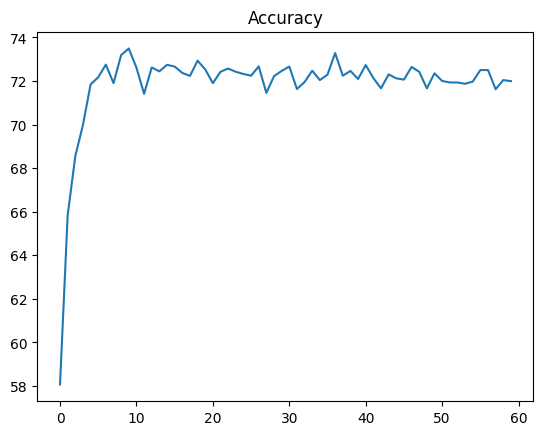

In [30]:
plt.plot(accuracy)
plt.title('Accuracy')
plt.show()

In [31]:
print("Maximum accuracy of the network on the 10000 test images: {} at epoch {}".format(np.max(accuracy), np.argmax(accuracy)))

Maximum accuracy of the network on the 10000 test images: 73.49 at epoch 9


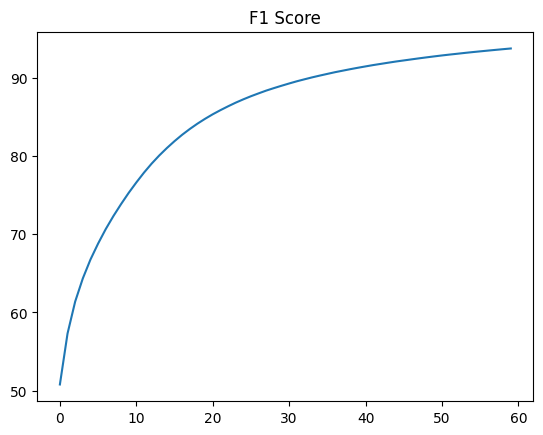

In [32]:
plt.plot(torch.stack(f1).cpu())
plt.title('F1 Score')
plt.show()

# Optimal Learning Rate
### Hyperparameters

In [33]:
batch_size = 64
num_classes = 100
learning_rate = [1,0.1,0.01,0.001,0.0001,0.00001]
num_epochs = 17
error = []
accuracy = []
metric_f1 = torchmetrics.F1Score(task='multiclass', num_classes = num_classes).to(device)

# Set up and run the CNN
Record the error at the end of each iteration

In [34]:
for i in learning_rate:    
    model = LeNet_mod(num_classes = num_classes).to(device)
    
    cost = F.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=i)
    
    total_step = len(train_loader)
    error.append([])
    for epoch in range(num_epochs):
        
        for j, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = cost(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            error[-1].append(loss.item())
            metric_f1.update(outputs, labels)
            
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                output = model(images)
                _, predicted = torch.max(output.data, 1)
                total+=labels.size(0)
                correct+=(predicted == labels).sum().item()
            accuracy.append(100 * correct / total)
            print(f'Learning Rate {i}.. ')
            print(f'Epoch {epoch+1}/{num_epochs}.. ')
            print(f'F1Score: {(100* metric_f1.compute()):.4f}%')
            print(f'Accuracy: {accuracy[-1]:.4f}%')

Learning Rate 1.. 
Epoch 1/17.. 
F1Score: 10.0320%
Accuracy: 10.0000%
Learning Rate 1.. 
Epoch 2/17.. 
F1Score: 10.0300%
Accuracy: 10.0000%
Learning Rate 1.. 
Epoch 3/17.. 
F1Score: 10.0740%
Accuracy: 10.0000%
Learning Rate 1.. 
Epoch 4/17.. 
F1Score: 10.0795%
Accuracy: 10.0000%
Learning Rate 1.. 
Epoch 5/17.. 
F1Score: 10.0968%
Accuracy: 10.0000%
Learning Rate 1.. 
Epoch 6/17.. 
F1Score: 10.0940%
Accuracy: 10.0000%
Learning Rate 1.. 
Epoch 7/17.. 
F1Score: 10.0791%
Accuracy: 10.0000%
Learning Rate 1.. 
Epoch 8/17.. 
F1Score: 10.0693%
Accuracy: 10.0000%
Learning Rate 1.. 
Epoch 9/17.. 
F1Score: 10.0742%
Accuracy: 10.0000%
Learning Rate 1.. 
Epoch 10/17.. 
F1Score: 10.0804%
Accuracy: 10.0000%
Learning Rate 1.. 
Epoch 11/17.. 
F1Score: 10.0915%
Accuracy: 10.0000%
Learning Rate 1.. 
Epoch 12/17.. 
F1Score: 10.0700%
Accuracy: 10.0000%
Learning Rate 1.. 
Epoch 13/17.. 
F1Score: 10.0572%
Accuracy: 10.0000%
Learning Rate 1.. 
Epoch 14/17.. 
F1Score: 10.0567%
Accuracy: 10.0000%
Learning Rate 1

### Graphs

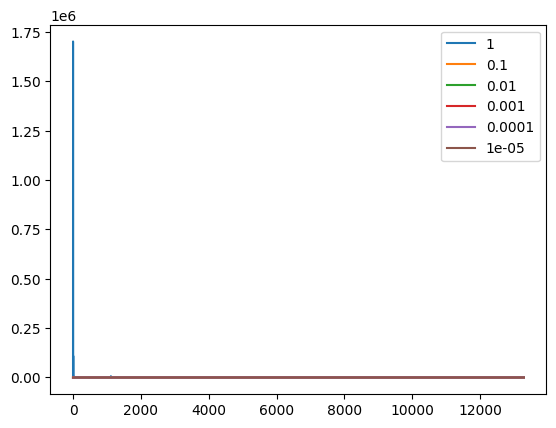

In [35]:
for i in range(len(error)):
    plt.plot(error[i], label='{}'.format(learning_rate[i]))
plt.legend()
plt.show()

##### Remove the first 2 cases because the scale is thrown off.

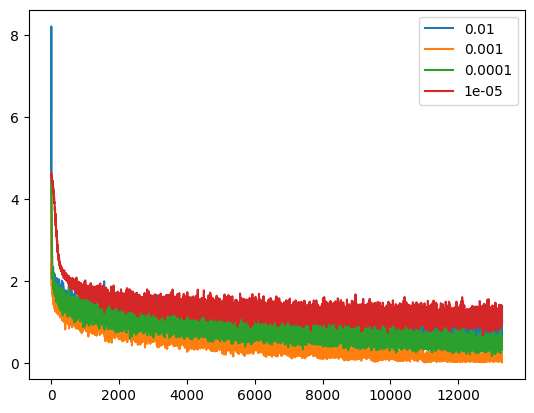

In [36]:
for i in range(2,len(error)):
    plt.plot(error[i], label='{}'.format(learning_rate[i]))
plt.legend()
plt.show()

##### All Individual graphs

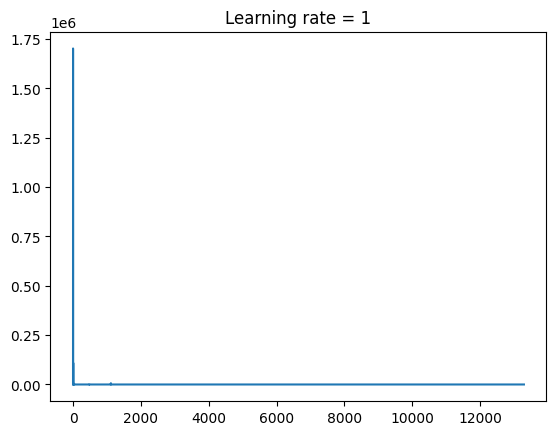

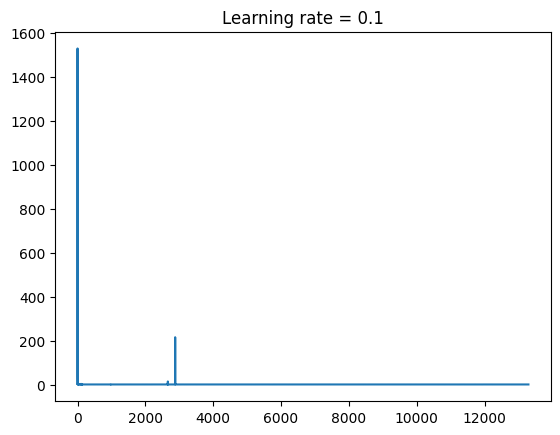

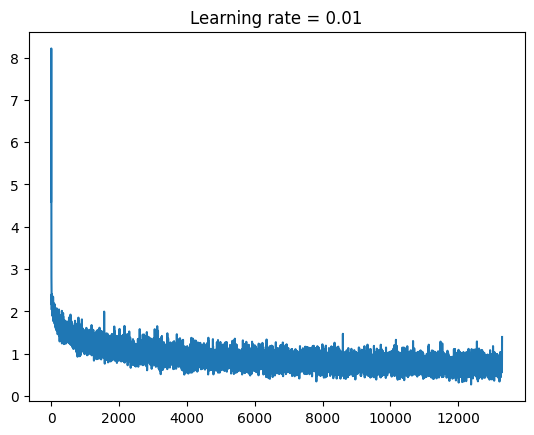

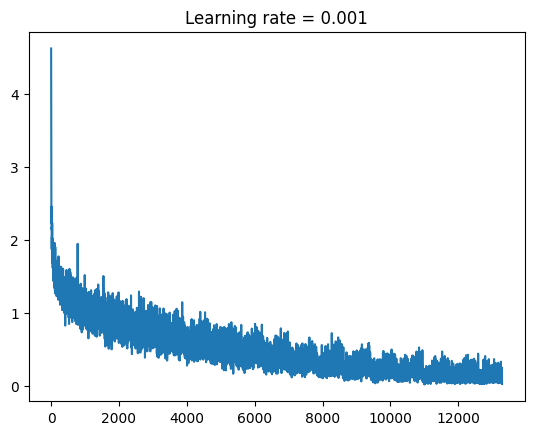

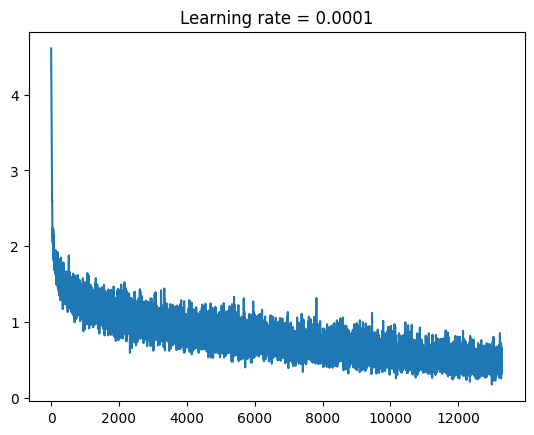

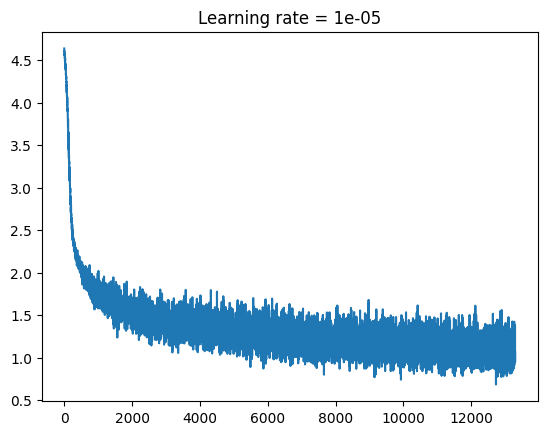

In [37]:
for i in range(len(error)):
    plt.plot(error[i], label='{}'.format(learning_rate[i]))
    plt.title('Learning rate = {}'.format(learning_rate[i]))
    plt.show()

# Adam Vs. SGD

### Hyperparameters

In [38]:
batch_size = 64
num_classes = 100
learning_rate = 0.001
num_epochs = 10
metric_f1 = torchmetrics.F1Score(task='multiclass', num_classes = num_classes).to(device)

### Set up Adam

In [39]:
model = LeNet_mod(num_classes = num_classes).to(device)

cost = F.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)

accuracy = [[],[]]

### Run the CNN with Adam
Record the accuracy at the end of each epoch

In [40]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = cost(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        metric_f1.update(outputs, labels)
        
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total+=labels.size(0)
            correct+=(predicted == labels).sum().item()
        accuracy[0].append(100 * correct / total)
        print(f'Epoch {epoch+1}/{num_epochs}.. ')
        print(f'F1Score: {(100* metric_f1.compute()):.4f}%')
        print(f'Accuracy: {accuracy[0][-1]:.4f}%')

Epoch 1/10.. 
F1Score: 50.3240%
Accuracy: 59.2100%
Epoch 2/10.. 
F1Score: 56.3590%
Accuracy: 63.3500%
Epoch 3/10.. 
F1Score: 60.3267%
Accuracy: 68.7000%
Epoch 4/10.. 
F1Score: 63.4065%
Accuracy: 68.5600%
Epoch 5/10.. 
F1Score: 65.8724%
Accuracy: 71.1500%
Epoch 6/10.. 
F1Score: 68.0370%
Accuracy: 72.0200%
Epoch 7/10.. 
F1Score: 69.9071%
Accuracy: 71.6100%
Epoch 8/10.. 
F1Score: 71.6160%
Accuracy: 72.1100%
Epoch 9/10.. 
F1Score: 73.2060%
Accuracy: 72.8300%
Epoch 10/10.. 
F1Score: 74.6576%
Accuracy: 71.9200%


### Set up SGD

In [41]:
model = LeNet_mod(num_classes = num_classes).to(device)

cost = F.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9)

total_step = len(train_loader)

accuracy[1] = []

### Run the CNN with SGD
Record the accuracy at the end of each epoch

In [42]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = cost(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        metric_f1.update(outputs, labels)
        
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total+=labels.size(0)
            correct+=(predicted == labels).sum().item()
        accuracy[1].append(100 * correct / total)
        print(f'Epoch {epoch+1}/{num_epochs}.. ')
        print(f'F1Score: {(100* metric_f1.compute()):.4f}%')
        print(f'Accuracy: {accuracy[1][-1]:.4f}%')

Epoch 1/10.. 
F1Score: 71.9927%
Accuracy: 53.4900%
Epoch 2/10.. 
F1Score: 71.0865%
Accuracy: 63.2900%
Epoch 3/10.. 
F1Score: 70.8088%
Accuracy: 68.9900%
Epoch 4/10.. 
F1Score: 70.9230%
Accuracy: 69.4400%
Epoch 5/10.. 
F1Score: 71.2612%
Accuracy: 71.7500%
Epoch 6/10.. 
F1Score: 71.7570%
Accuracy: 73.2300%
Epoch 7/10.. 
F1Score: 72.3626%
Accuracy: 73.6400%
Epoch 8/10.. 
F1Score: 73.0521%
Accuracy: 73.3700%
Epoch 9/10.. 
F1Score: 73.8017%
Accuracy: 74.0300%
Epoch 10/10.. 
F1Score: 74.5789%
Accuracy: 74.0800%


### Graph

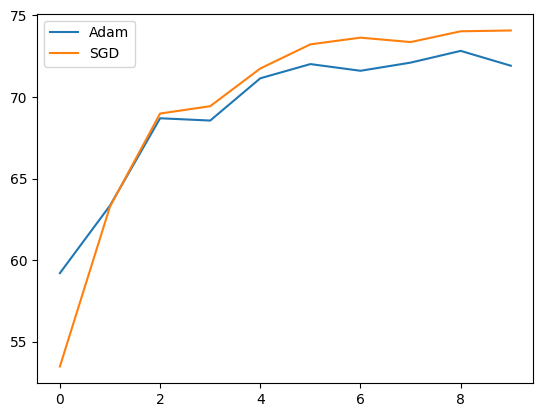

In [46]:
plt.plot(accuracy[0], label='Adam')
plt.plot(accuracy[1], label='SGD')
plt.legend()
plt.show()